<a href="https://colab.research.google.com/github/DIWEERAPURA/Image-Processing-CV-Projects-and-Deep-Learning-Vision-Tasks/blob/main/SkinTypeDetection_Simulated_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Step 1: Install Dependencies (if needed)
# Uncomment and run the following cell if pygad is not installed.
!pip install pygad --quiet
!pip install opencv-python --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.9 MB/s eta 0:00:00


In [2]:
#@title Step 2: Import Libraries and Check GPU
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
import pygad

# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


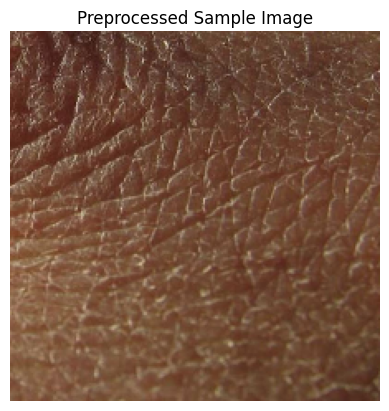

In [5]:
#@title Step 3: Define Global Parameters and Preprocessing Function

# Define image dimensions (MobileNetV2 expects 224x224)
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Path to your dataset folder.
# Ensure you upload your folder to Colab (e.g., via the left sidebar or mounting Google Drive).
dataset_path = '/content/drive/MyDrive/DataSet'

# Define the classes in the given order.
classes = ['Dry Skin', 'Acne Skin', 'Oily Skin', 'Normal Skin']
num_classes = len(classes)

def preprocess_image(image_path):
    """
    Load an image from disk, resize it and apply preprocessing:
      - Grayscale conversion
      - Image blurring
      - Gaussian blurring
      - Canny edge detection
      - Thresholding and contour detection
    Note: For feeding a pre-trained model we convert back to RGB.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply simple blurring
    blur = cv2.blur(gray, (3,3))

    # Apply Gaussian blurring
    gauss = cv2.GaussianBlur(blur, (5,5), 0)

    # Canny edge detection
    edges = cv2.Canny(gauss, 100, 200)

    # Thresholding
    ret, thresh = cv2.threshold(gauss, 127, 255, cv2.THRESH_BINARY)

    # Contour detection (this returns contours; you can modify further if needed)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For this pipeline, we use the original resized image (converted to RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# (Optional) Visualize preprocessing on one sample image
sample_path = os.path.join(dataset_path, classes[0])
sample_files = [os.path.join(sample_path, f) for f in os.listdir(sample_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
if sample_files:
    sample_img = preprocess_image(sample_files[0])
    plt.imshow(sample_img)
    plt.title("Preprocessed Sample Image")
    plt.axis('off')
    plt.show()


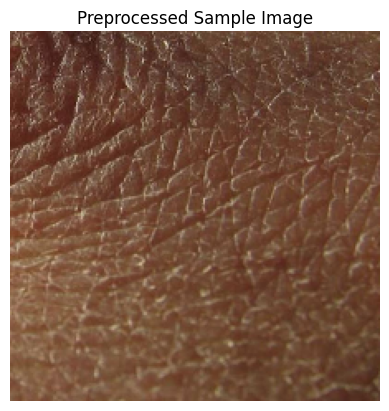

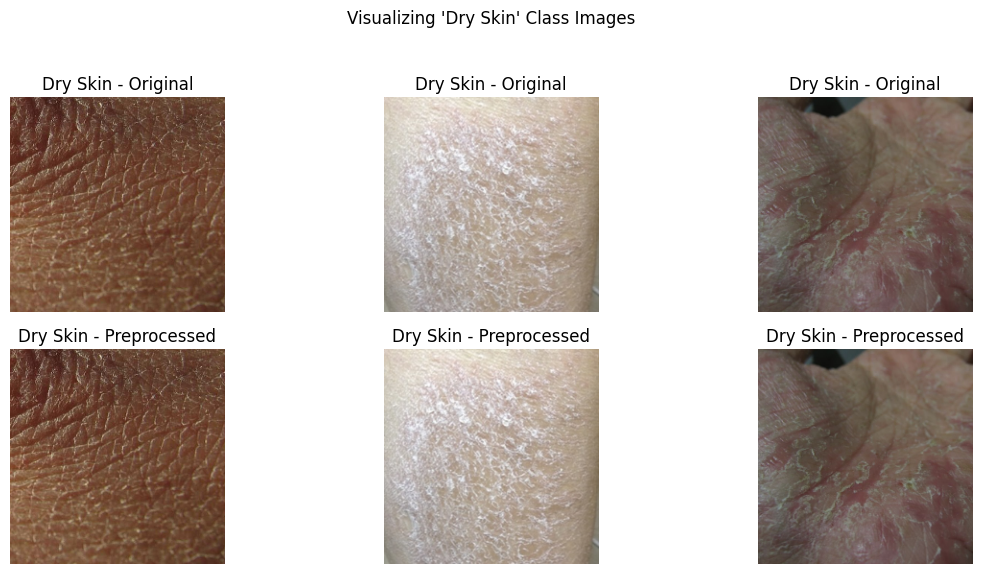

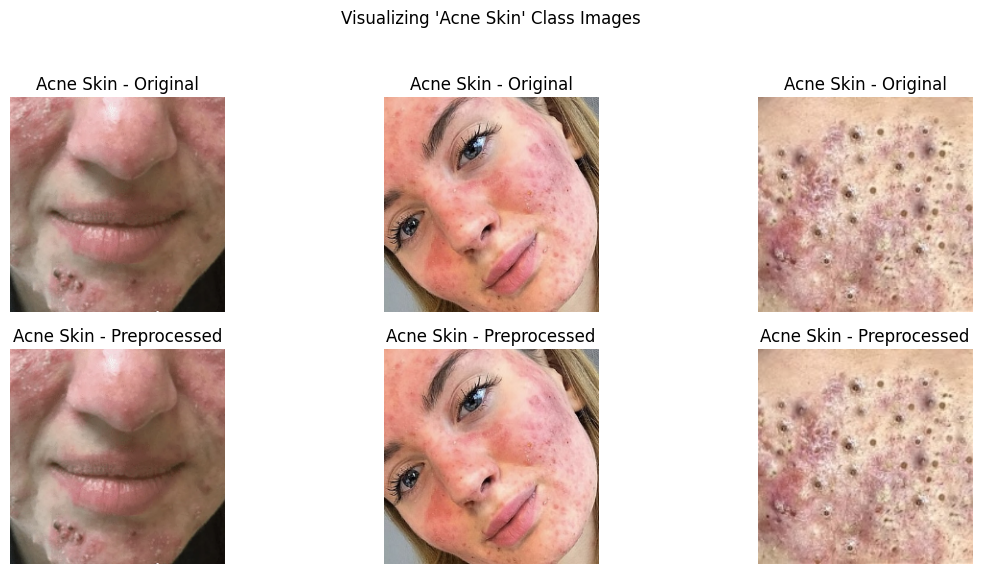

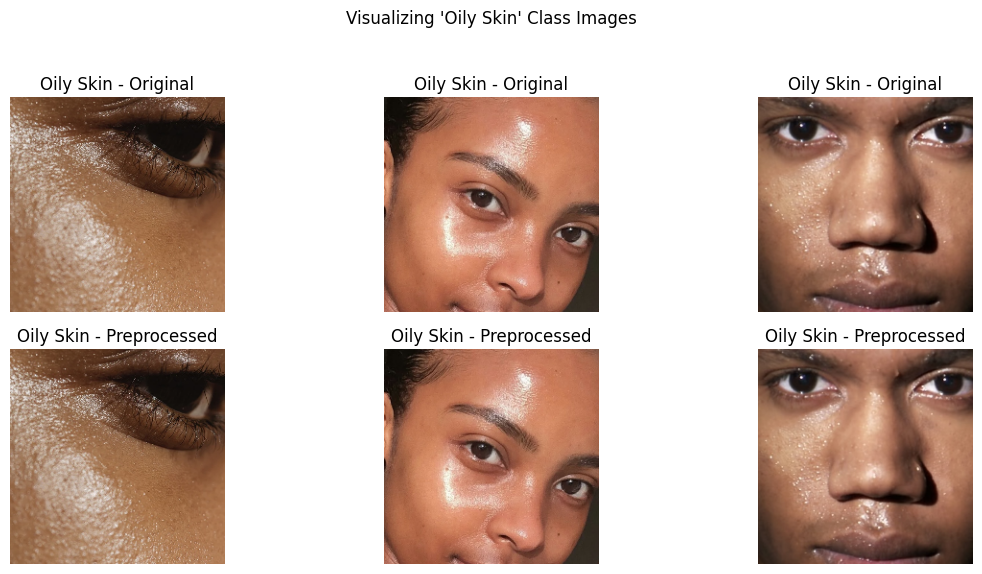

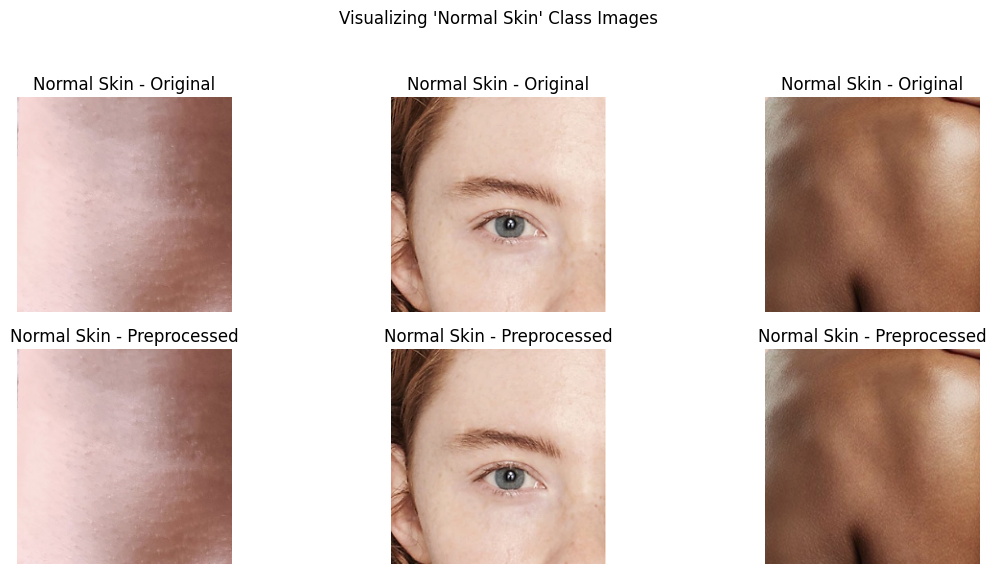

In [6]:
#@title Step 3: Define Global Parameters and Preprocessing Function

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define image dimensions (MobileNetV2 expects 224x224)
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Path to your dataset folder.
# Ensure you upload your folder to Colab (e.g., via the left sidebar or mounting Google Drive).
dataset_path = '/content/drive/MyDrive/DataSet'

# Define the classes in the given order.
classes = ['Dry Skin', 'Acne Skin', 'Oily Skin', 'Normal Skin']
num_classes = len(classes)

def preprocess_image(image_path):
    """
    Load an image from disk, resize it and apply preprocessing:
      - Grayscale conversion
      - Image blurring
      - Gaussian blurring
      - Canny edge detection
      - Thresholding and contour detection
    Note: For feeding a pre-trained model we convert back to RGB.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply simple blurring
    blur = cv2.blur(gray, (3,3))

    # Apply Gaussian blurring
    gauss = cv2.GaussianBlur(blur, (5,5), 0)

    # Canny edge detection
    edges = cv2.Canny(gauss, 100, 200)

    # Thresholding
    ret, thresh = cv2.threshold(gauss, 127, 255, cv2.THRESH_BINARY)

    # Contour detection (this returns contours; you can modify further if needed)
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # For this pipeline, we use the original resized image (converted to RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# (Optional) Visualize preprocessing on one sample image from the first class folder
sample_path = os.path.join(dataset_path, classes[0])
sample_files = [os.path.join(sample_path, f) for f in os.listdir(sample_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
if sample_files:
    sample_img = preprocess_image(sample_files[0])
    plt.imshow(sample_img)
    plt.title("Preprocessed Sample Image")
    plt.axis('off')
    plt.show()


# ------------------------------
# New Code: Visualization of Each Class (Before and After Preprocessing)
# ------------------------------

def load_original_image(image_path):
    """
    Loads the original image, resizes it to the expected dimensions,
    and converts it to RGB for display.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

# Visualize original and preprocessed images for each class
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No images found in {class_folder}")
        continue

    # Select a few sample images; here we choose the first 3 images (or fewer if not enough images)
    sample_files = image_files[:3]

    plt.figure(figsize=(12, 6))
    for i, file in enumerate(sample_files):
        # Load the original image (before preprocessing)
        orig = load_original_image(file)
        # Apply preprocessing to the image
        processed = preprocess_image(file)

        # Display the original image
        plt.subplot(2, len(sample_files), i+1)
        plt.imshow(orig)
        plt.title(f"{class_name} - Original")
        plt.axis('off')

        # Display the preprocessed image
        plt.subplot(2, len(sample_files), i+1+len(sample_files))
        plt.imshow(processed)
        plt.title(f"{class_name} - Preprocessed")
        plt.axis('off')

    plt.suptitle(f"Visualizing '{class_name}' Class Images")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
#@title Step 4: Load the Dataset and Encode Labels

images = []
labels = []

# Loop over each class folder in the order provided
for idx, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_folder):
        print("Folder not found:", class_folder)
        continue
    for file in os.listdir(class_folder):
        file_path = os.path.join(class_folder, file)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = preprocess_image(file_path)
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

images = np.array(images)
labels = np.array(labels)

# One-hot encode the labels
labels_cat = to_categorical(labels, num_classes=num_classes)

# Normalize image data to [0, 1]
images = images.astype('float32') / 255.0

print("Images shape:", images.shape)
print("Labels shape:", labels_cat.shape)


Images shape: (1343, 224, 224, 3)
Labels shape: (1343, 4)


In [8]:
#@title Step 5: Split the Dataset
# First split into train (70%) and temporary (30%) sets; then split temporary into validation and test (each 15%)
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels_cat, test_size=0.3, random_state=42, stratify=labels)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)


Training set: (940, 224, 224, 3) (940, 4)
Validation set: (201, 224, 224, 3) (201, 4)
Test set: (202, 224, 224, 3) (202, 4)


In [9]:
#@title Step 6: Build the Base CNN Model Using MobileNetV2

# Load MobileNetV2 without the top classification layers.
# We set weights to 'imagenet' so the model has learned useful features.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model initially

def build_model(learning_rate=1e-4, dropout_rate=0.5, fine_tune_layers=0):
    """
    Builds and compiles a CNN model using MobileNetV2 as the base.
    The model architecture:
      - MobileNetV2 (frozen or partially unfrozen based on fine_tune_layers)
      - Global Average Pooling
      - Dropout layer with dropout_rate
      - Dense softmax layer for classification
    """
    # Optionally fine-tune the last 'fine_tune_layers' layers of MobileNetV2
    if fine_tune_layers > 0:
        base_model.trainable = True
        # Freeze all layers except the last 'fine_tune_layers'
        for layer in base_model.layers[:-fine_tune_layers]:
            layer.trainable = False
        for layer in base_model.layers[-fine_tune_layers:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example: Build and inspect a model using default hyperparameters
model_example = build_model()
model_example.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
import pygad
import tensorflow as tf

# Updated fitness function accepting three parameters: ga_instance, solution, and sol_idx.
def fitness_func(ga_instance, solution, sol_idx):
    # Extract hyperparameters from the solution vector
    learning_rate = solution[0]           # Expected range: [1e-5, 1e-3]
    dropout_rate = solution[1]            # Expected range: [0.3, 0.7]
    fine_tune_layers = int(solution[2])   # Expected range: [0, 20]

    print(f"GA eval solution {sol_idx}: lr={learning_rate:.5f}, dropout={dropout_rate:.2f}, fine_tune_layers={fine_tune_layers}")

    # Build the model with the candidate hyperparameters
    model = build_model(learning_rate=learning_rate, dropout_rate=dropout_rate, fine_tune_layers=fine_tune_layers)

    # Train for a few epochs to keep the evaluation fast (adjust epochs as needed)
    history = model.fit(x_train, y_train, epochs=3, batch_size=16, verbose=0, validation_data=(x_val, y_val))
    val_acc = history.history['val_accuracy'][-1]

    # Clean up session to prevent GPU memory buildup
    tf.keras.backend.clear_session()

    return val_acc

# Define gene space for the three hyperparameters
gene_space = [
    {'low': 1e-5, 'high': 1e-3},       # learning_rate
    {'low': 0.3, 'high': 0.7},         # dropout_rate
    {'low': 0, 'high': 20, 'step': 1}    # fine_tune_layers
]

# Initialize and run the GA
ga_instance = pygad.GA(num_generations=5,
                       num_parents_mating=2,
                       fitness_func=fitness_func,
                       sol_per_pop=4,
                       num_genes=3,
                       gene_space=gene_space,
                       mutation_percent_genes=50,
                       mutation_type="random",
                       stop_criteria=["reach_0.95"],
                       suppress_warnings=True)

ga_instance.run()

# Retrieve the best solution from GA
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best GA solution:", solution, "with fitness (val accuracy):", solution_fitness)


GA eval solution 0: lr=0.00034, dropout=0.43, fine_tune_layers=14
GA eval solution 1: lr=0.00070, dropout=0.56, fine_tune_layers=15
GA eval solution 2: lr=0.00041, dropout=0.50, fine_tune_layers=6
GA eval solution 3: lr=0.00036, dropout=0.55, fine_tune_layers=17
GA eval solution 1: lr=0.00001, dropout=0.56, fine_tune_layers=15
GA eval solution 2: lr=0.00070, dropout=0.50, fine_tune_layers=7
GA eval solution 3: lr=0.00070, dropout=0.30, fine_tune_layers=15
GA eval solution 1: lr=0.00070, dropout=0.70, fine_tune_layers=7
GA eval solution 3: lr=0.00001, dropout=0.30, fine_tune_layers=7
GA eval solution 1: lr=0.00001, dropout=0.30, fine_tune_layers=15
GA eval solution 2: lr=0.00001, dropout=0.70, fine_tune_layers=7
GA eval solution 1: lr=0.00070, dropout=0.30, fine_tune_layers=15
GA eval solution 2: lr=0.00001, dropout=0.30, fine_tune_layers=7
GA eval solution 3: lr=0.00001, dropout=0.70, fine_tune_layers=15
GA eval solution 2: lr=0.00001, dropout=0.30, fine_tune_layers=0
GA eval solution 

In [14]:
#@title Step 8: Final Model Training and Evaluation

# Extract the best hyperparameters from the GA solution
best_lr = solution[0]
best_dropout = solution[1]
best_fine_tune = int(solution[2])
print(f"Final hyperparameters: learning_rate={best_lr:.5f}, dropout_rate={best_dropout:.2f}, fine_tune_layers={best_fine_tune}")

# Build the final model using the best-found hyperparameters
final_model = build_model(learning_rate=best_lr, dropout_rate=best_dropout, fine_tune_layers=best_fine_tune)
final_model.summary()

# Train the final model further on the training set (you can increase epochs as needed)
history_final = final_model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)


Final hyperparameters: learning_rate=0.00070, dropout_rate=0.70, fine_tune_layers=7


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 727,044 (2.77 MB)

 Non-trainable params: 1,536,064 (5.86 MB)

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8478 - loss: 0.4962 - val_accuracy: 0.8259 - val_loss: 0.8459
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9851 - loss: 0.0521 - val_accuracy: 0.8507 - val_loss: 0.5240
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.8408 - val_loss: 0.5400
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9933 - loss: 0.0415 - val_accuracy: 0.8259 - val_loss: 1.0082
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9959 - loss: 0.0169 - val_accuracy: 0.8308 - val_loss: 0.9383
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9861 - loss: 0.0370 - val_accuracy: 0.8408 - val_loss: 0.9524
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9932 - loss: 0.0222 - val_accuracy: 0.8507 - val_loss: 1.0213
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9945 - loss: 0.0230 - val_accuracy: 0.8458 -

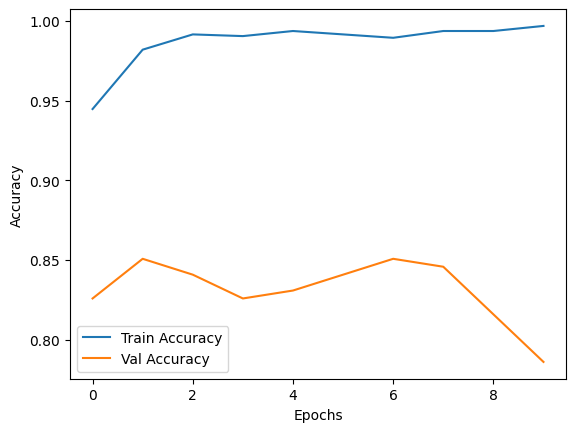

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [3]:
#@title Install Dependencies
!pip install -q pygad
!pip install -q opencv-python-headless


In [4]:
#@title Import Libraries and Define Global Parameters
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pygad

# Image dimensions (EfficientNetB0 typically uses 224x224)
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Path to your dataset folder (upload or mount your folder in Colab)
DATASET_PATH = '/content/drive/MyDrive/DataSet'

# Define the classes in the given order.
classes = ['Dry Skin', 'Acne Skin', 'Oily Skin', 'Normal Skin']
num_classes = len(classes)


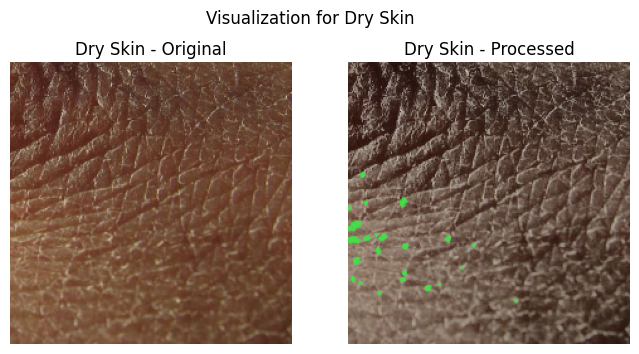

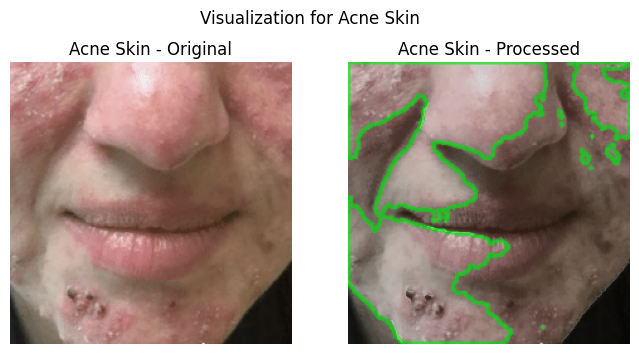

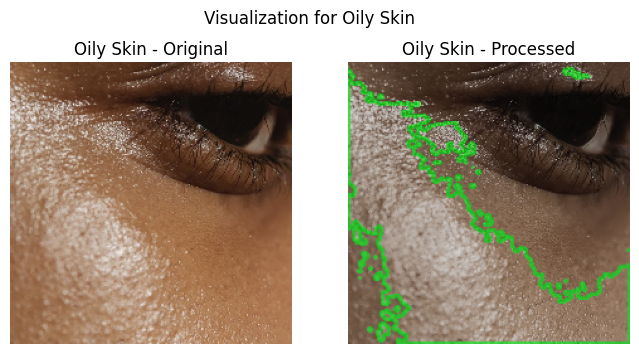

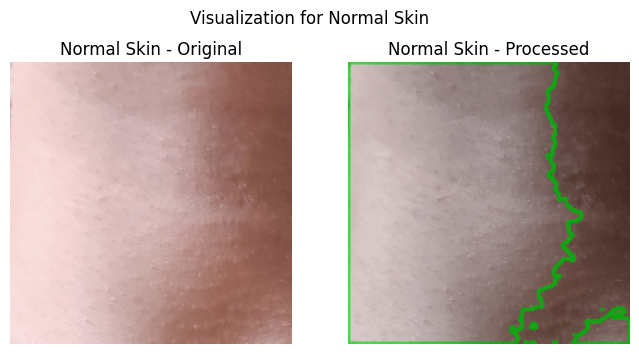

In [5]:
#@title Define Custom Preprocessing and Feature Engineering Functions
def custom_preprocess(image_path):
    """
    Loads an image, resizes it, and applies advanced feature engineering:
      - Grayscale conversion
      - Image blurring (simple and Gaussian)
      - Canny edge detection
      - Thresholding and contour detection
      - Histogram equalization for contrast enhancement
      - Combining processed features for a composite output
    The output is a 3-channel RGB image ready for further processing.
    """
    # Load and resize image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply simple blurring
    blur = cv2.blur(gray, (3, 3))

    # Apply Gaussian blurring
    gauss = cv2.GaussianBlur(blur, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(gauss, 100, 200)

    # Apply thresholding (binary threshold)
    ret, thresh = cv2.threshold(gauss, 127, 255, cv2.THRESH_BINARY)

    # Detect contours from the thresholded image
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw detected contours on a copy of the original image
    contour_img = image.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    # Convert edges to a 3-channel image for combination
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Create a composite image: overlay edges on the contour image
    composite = cv2.addWeighted(contour_img, 0.8, edges_colored, 0.2, 0)

    # Enhance contrast using histogram equalization on the grayscale image
    eq = cv2.equalizeHist(gray)
    eq_colored = cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)

    # Combine the composite image with the equalized image
    final_img = cv2.addWeighted(composite, 0.7, eq_colored, 0.3, 0)

    # Convert the final image from BGR to RGB for proper visualization
    final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

    return final_img_rgb

# For visualization: Show one image per class (original vs. custom preprocessed)
for cls in classes:
    folder = os.path.join(DATASET_PATH, cls)
    image_files = [os.path.join(folder, f) for f in os.listdir(folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) == 0:
        print(f"No images found in {folder}")
        continue
    # Select the first image for visualization
    # Load the raw image (original)
    raw = cv2.imread(image_files[0])
    raw = cv2.resize(raw, (IMG_WIDTH, IMG_HEIGHT))
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)

    # Processed image with advanced steps
    processed = custom_preprocess(image_files[0])

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(raw)
    plt.title(f"{cls} - Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed)
    plt.title(f"{cls} - Processed")
    plt.axis('off')
    plt.suptitle(f"Visualization for {cls}")
    plt.show()


In [6]:
#@title Load Dataset and Prepare Labels
images = []
labels = []

for idx, cls in enumerate(classes):
    folder = os.path.join(DATASET_PATH, cls)
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}")
        continue
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = custom_preprocess(os.path.join(folder, file))
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Error processing {file}: {e}")

images = np.array(images)
labels = np.array(labels)

# One-hot encode labels
y = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

print("Dataset shape:", images.shape, y.shape)


Dataset shape: (1343, 224, 224, 3) (1343, 4)


In [7]:
#@title Split the Dataset into Training, Validation, and Test Sets
from sklearn.model_selection import train_test_split

# Split: 70% training, 15% validation, 15% test.
x_train, x_temp, y_train, y_temp = train_test_split(
    images, y, test_size=0.3, random_state=42, stratify=labels)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)


Training set: (940, 224, 224, 3) (940, 4)
Validation set: (201, 224, 224, 3) (201, 4)
Test set: (202, 224, 224, 3) (202, 4)


In [8]:
#@title Set Up Advanced Data Augmentation and Preprocessing Generators
# Training generator with advanced augmentation and EfficientNet-specific preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=efficientnet_preprocess  # Normalizes & standardizes input for EfficientNet
)

# For validation and test: only apply EfficientNet preprocessing.
test_val_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

# Create generators (set a moderate batch size for efficient processing)
batch_size = 32

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
val_generator = test_val_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)
test_generator = test_val_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)


In [9]:
#@title Define the Model Building Function with EfficientNetB0 and Gradual Unfreezing
def build_model(learning_rate=1e-4, dropout_rate=0.5, fine_tune_layers=10):
    """
    Builds and compiles a CNN model using EfficientNetB0 as the base.
    Gradual unfreezing: Freeze all layers except the last `fine_tune_layers` of the base model.
    """
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # Initially set all layers trainable, then freeze layers except last few.
    base_model.trainable = True
    if fine_tune_layers < len(base_model.layers):
        for layer in base_model.layers[:-fine_tune_layers]:
            layer.trainable = False
        for layer in base_model.layers[-fine_tune_layers:]:
            layer.trainable = True
    else:
        base_model.trainable = True  # If fine_tune_layers exceeds, unfreeze all.

    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    # You can add L2 regularization to Dense if needed:
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example: inspect model summary with default hyperparameters
model_example = build_model()
model_example.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 898,356 (3.43 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [10]:
#@title Define Callbacks for Regularization and Overfitting Prevention
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [11]:
pip install pygad tensorflow numpy


In [ ]:
#@title Simulated Annealing for Hyperparameter Tuning

import numpy as np
import tensorflow as tf
from scipy.optimize import dual_annealing

# Define the fitness function for Simulated Annealing
def fitness_func(solution, *args):
    lr, dropout, fine_tune = solution
    print(f"Evaluating: lr={lr:.5e}, dropout={dropout:.2f}, fine_tune_layers={int(fine_tune)}")

    # Build and compile the model with the given hyperparameters
    model = build_model(learning_rate=lr, dropout_rate=dropout, fine_tune_layers=int(fine_tune))

    # Train the model on a subset of data for faster evaluation
    history = model.fit(train_generator,
                        steps_per_epoch=10,  # Use 10 steps per epoch
                        epochs=3,            # Use 3 epochs
                        validation_data=val_generator,
                        validation_steps=5,
                        verbose=0)

    # Extract the validation accuracy from the training history
    val_acc = history.history['val_accuracy'][-1]

    # Clear the Keras session to free up resources
    tf.keras.backend.clear_session()

    # Return the negative validation accuracy as we aim to maximize accuracy
    return -val_acc

# Define the bounds for the hyperparameters
param_bounds = [(1e-5, 1e-3),  # Learning rate
                (0.3, 0.7),    # Dropout rate
                (5, 50)]       # Number of layers to unfreeze

# Perform Simulated Annealing optimization
result = dual_annealing(fitness_func, bounds=param_bounds, maxiter=10, seed=42)

# Extract the best hyperparameters found
best_lr, best_dropout, best_fine_tune = result.x
print(f"Best Hyperparameters: lr={best_lr:.5e}, dropout={best_dropout:.2f}, fine_tune_layers={int(best_fine_tune)}")


Evaluating: lr=3.80795e-04, dropout=0.68, fine_tune_layers=37


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Evaluating: lr=4.97024e-04, dropout=0.47, fine_tune_layers=43
Evaluating: lr=6.34299e-05, dropout=0.39, fine_tune_layers=5
Evaluating: lr=3.71381e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=9.25695e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=9.25695e-04, dropout=0.46, fine_tune_layers=26
Evaluating: lr=9.25695e-04, dropout=0.46, fine_tune_layers=38
Evaluating: lr=9.25695e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=9.25705e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=9.25695e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=9.25695e-04, dropout=0.67, fine_tune_layers=26
Evaluating: lr=1.00000e-03, dropout=0.70, fine_tune_layers=50
Evaluating: lr=9.99990e-04, dropout=0.70, fine_tune_layers=50
Evaluating: lr=1.00000e-03, dropout=0.70, fine_tune_layers=50
Evaluating: lr=1.00000e-03, dropout=0.70, fine_tune_layers=49
Evaluating: lr=9.56536e-04, dropout=0.68, fine_tune_layers=36
Evaluating: lr=9.56546e-04, dropout=0.68, fine_tune_layers=36
Evaluatin